# default decoding results analysis

* save `Rs` over subjects ("decodability") to phenotype folder
* compare between groups
* corr. with behavioral params

In [8]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

bids_folder = '/mnt_03/ds-dnumrisk' #'/Users/mrenke/data/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]
target_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'



In [9]:
from numrisk.utils.data import get_data_magjduge

df = get_data_magjduge(bids_folder=bids_folder)

number of subjects found: 66


In [10]:
from utils import get_decoding_info

pred = []
for sub in subjects:
    pred.append(get_decoding_info(sub,bids_folder=bids_folder))

pred = pd.concat(pred).join(df, how='inner')

/mnt_03/ds-dnumrisk/derivatives/decoded_pdfs_stim1.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv


In [11]:
import pingouin as pg

r = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d['log(n1)']))
# save 
# r.reset_index(['group', None])[['r']].to_csv(op.join(target_folder,'decoding_r.csv'))

/tmp/ipykernel_1998623/2800112131.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = pred.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d['log(n1)']))


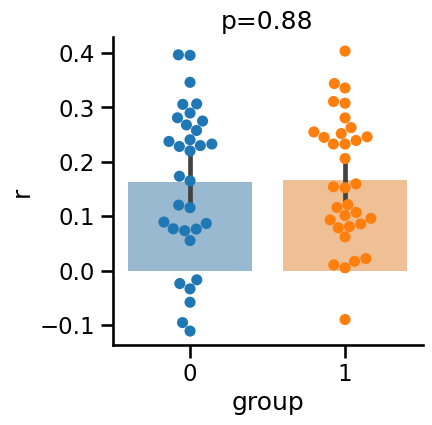

In [7]:
temp = r#.groupby(['subject','group']).mean()
sns.set_context('talk')

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var,  hue='group', alpha=0.5,legend=False)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()

## Compare with behavior

In [7]:
source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

magjudge_probit_params = pd.read_csv(op.join(source_folder,'probit-2_all-subwise-params.csv')).set_index('subject')

gammas_symbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-symbolic_gammas.csv'))
gammas_symbolic = gammas_symbolic.set_index('subject').drop(columns=['Unnamed: 0'])

df_comb = r.reset_index(['group', None])[['r', 'group']].join(magjudge_probit_params, how='inner').join(gammas_symbolic, how='inner',rsuffix='_symbolic')
df_comb.head()

,r,group,gamma,intercept,n1|subject,gamma_symbolic
subject,,,,,,
1,-0.058083,0,4.583617,-0.177108,-0.009172,4.144728
2,0.206071,1,3.547053,0.021933,0.000715,0.804526
4,-0.089840,1,5.052103,-0.160951,-0.009397,1.937536
5,-0.023735,0,3.478226,-0.255322,-0.012253,2.407660
6,0.062036,1,4.457349,-0.063814,-0.006156,2.204173


In [10]:
model_label =3 # 1 n1_evidence_sd & n2_evidence_sd, 3 = memory_noise_sd & perceptual_noise_sd
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-{model_label}_sds.csv')).set_index('subject')

df_comb = r.reset_index(['group', None])[['r']].join(magjudge_bauer_params, how='inner')
df_comb.head()

,r,memory_noise_sd,perceptual_noise_sd,group
subject,,,,
1,-0.058083,0.128094,0.074870,0
2,0.206071,0.222981,0.052561,1
4,-0.089840,0.178991,0.021833,1
5,-0.023735,0.130870,0.126985,0
6,0.062036,0.194349,0.028768,1


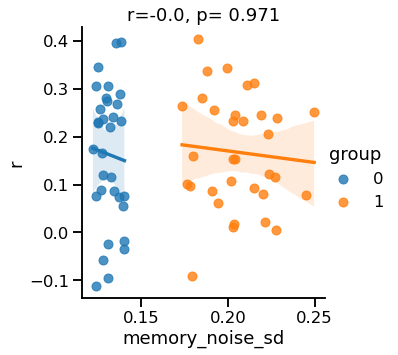

In [12]:
import pingouin

#df_comb = df_comb[df_comb['group'] == 1]
y_var = 'r' 
x_var = 'memory_noise_sd'#'perceptual_noise_sd'#'n2_evidence_sd'#'gamma'

cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group') # 
fig.set(title=f'r={r_}, p= {p}') 